In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



#1.Importing Libraries



In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import sys
import matplotlib.pyplot as plt
import numpy as np
import random
# from torch_receptive_field import PytorchReceptiveField
!pip install torchsummary

# 2. Mount Google Drive to get the files individual files


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!rm -rf '/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/__pycache__'
!ls -lrt '/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/'

total 885
-rw------- 1 root root   3326 Sep 12 08:32 customModel.py
-rw------- 1 root root   1779 Sep 12 09:32 trainModel.py
-rw------- 1 root root   2214 Sep 12 09:43 vs_net.py
-rw------- 1 root root   1541 Sep 12 09:50 testModel.py
-rw------- 1 root root   1642 Sep 12 16:18 README.md
drwx------ 2 root root   4096 Sep 19 10:23 Images
-rw------- 1 root root   4261 Sep 19 11:11 resnet.py
-rw------- 1 root root 879751 Sep 19 12:08 main
-rw------- 1 root root   4770 Sep 19 12:32 dataTorchTransformLoad.py


## 2.1 Add Googledrive path to the systempath  


In [14]:
sys.path.append('/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/')

# Importing Custom Libraries
 1. DataTransformers
 2. TrainModel
 3. TestModel
 4. Custom Model
 5. Advanced Model
 6. Resnet


In [15]:
import dataTorchTransformLoad as dtl
import trainModel
import testModel
import customModel
import vs_net
import resnet

# 3. Train - Test Data Load with torch transforms


In [16]:
train,test,train_loader,test_loader = dtl.data_transform_and_load_function('CIFAR10',64)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


## 4.1 Data Statistics

In [17]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


## 4.2 Display data

[['plane' 'dog' 'deer' 'deer' 'truck' 'cat' 'truck' 'truck']
 ['cat' 'cat' 'plane' 'horse' 'plane' 'dog' 'dog' 'deer']
 ['car' 'car' 'frog' 'car' 'frog' 'dog' 'ship' 'cat']
 ['car' 'frog' 'deer' 'bird' 'deer' 'bird' 'cat' 'horse']
 ['car' 'cat' 'cat' 'ship' 'horse' 'plane' 'plane' 'plane']
 ['truck' 'plane' 'frog' 'horse' 'ship' 'deer' 'bird' 'plane']
 ['cat' 'dog' 'bird' 'truck' 'dog' 'cat' 'deer' 'dog']
 ['dog' 'frog' 'horse' 'frog' 'ship' 'deer' 'plane' 'truck']]


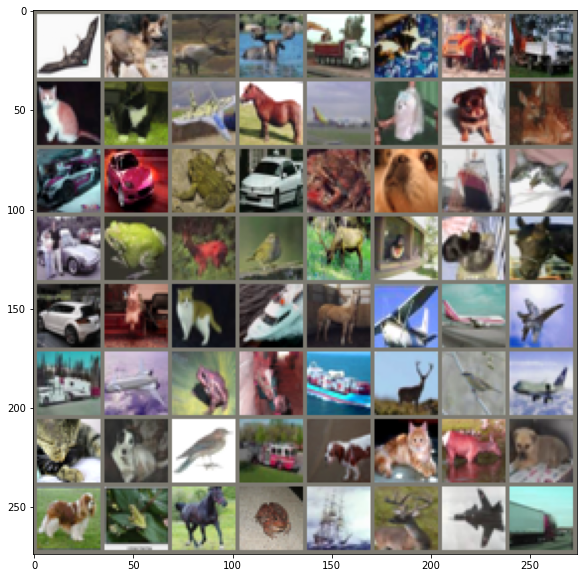

In [18]:
# functions to show an image
def imageshow(img):
    # img = img / 2 + 0.5      #unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

random.seed(1)
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
random.seed(1)
imageshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(64)))
print(np.array([classes[labels[j]] for j in range(64)]).reshape(8,8))

## 5. Previous Architecture

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = customModel.Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 30, 30]             270
       BatchNorm2d-2           [-1, 10, 30, 30]              20
              ReLU-3           [-1, 10, 30, 30]               0
           Dropout-4           [-1, 10, 30, 30]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
              ReLU-7           [-1, 10, 28, 28]               0
           Dropout-8           [-1, 10, 28, 28]               0
            Conv2d-9           [-1, 16, 26, 26]           1,440
      BatchNorm2d-10           [-1, 16, 26, 26]              32
             ReLU-11           [-1, 16, 26, 26]               0
          Dropout-12           [-1, 16, 26, 26]               0
        MaxPool2d-13           [-1, 16, 13, 13]               0
           Conv2d-14           [-1

## 10K Params, Average loss: 0.9891, Accuracy: 6501/10000 (65.01%)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.299631118774414 Batch_id=0 Accuracy=17.19:   0%|          | 0/782 [00:00<?, ?it/s]/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/trainModel.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device).clone().detach().requires_grad_(True)
Loss=1.8002852201461792 Batch_id=781 Accuracy=38.07: 100%|██████████| 782/782 [00:18<00:00, 41.63it/s]
/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/testModel.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, de


Test set: Average loss: 1.5215, Accuracy: 4472/10000 (44.72%)

EPOCH: 1


Loss=1.8996009826660156 Batch_id=781 Accuracy=50.00: 100%|██████████| 782/782 [00:18<00:00, 42.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3954, Accuracy: 4953/10000 (49.53%)

EPOCH: 2


Loss=1.6464202404022217 Batch_id=781 Accuracy=53.84: 100%|██████████| 782/782 [00:18<00:00, 42.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2215, Accuracy: 5692/10000 (56.92%)

EPOCH: 3


Loss=1.040554404258728 Batch_id=781 Accuracy=56.33: 100%|██████████| 782/782 [00:18<00:00, 42.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2326, Accuracy: 5577/10000 (55.77%)

EPOCH: 4


Loss=1.1412535905838013 Batch_id=781 Accuracy=58.01: 100%|██████████| 782/782 [00:18<00:00, 42.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1459, Accuracy: 5875/10000 (58.75%)

EPOCH: 5


Loss=1.191172480583191 Batch_id=781 Accuracy=59.05: 100%|██████████| 782/782 [00:18<00:00, 43.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1280, Accuracy: 5938/10000 (59.38%)

EPOCH: 6


Loss=1.2583106756210327 Batch_id=781 Accuracy=60.00: 100%|██████████| 782/782 [00:18<00:00, 42.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0765, Accuracy: 6154/10000 (61.54%)

EPOCH: 7


Loss=1.5598379373550415 Batch_id=781 Accuracy=60.74: 100%|██████████| 782/782 [00:18<00:00, 43.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0925, Accuracy: 6117/10000 (61.17%)

EPOCH: 8


Loss=1.6944386959075928 Batch_id=781 Accuracy=61.31: 100%|██████████| 782/782 [00:17<00:00, 43.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0646, Accuracy: 6290/10000 (62.90%)

EPOCH: 9


Loss=1.6496350765228271 Batch_id=781 Accuracy=61.57: 100%|██████████| 782/782 [00:17<00:00, 43.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0438, Accuracy: 6255/10000 (62.55%)

EPOCH: 10


Loss=0.7274390459060669 Batch_id=781 Accuracy=62.57: 100%|██████████| 782/782 [00:17<00:00, 44.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0322, Accuracy: 6314/10000 (63.14%)

EPOCH: 11


Loss=0.8537331819534302 Batch_id=781 Accuracy=62.63: 100%|██████████| 782/782 [00:17<00:00, 44.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0053, Accuracy: 6394/10000 (63.94%)

EPOCH: 12


Loss=0.8411110043525696 Batch_id=781 Accuracy=63.18: 100%|██████████| 782/782 [00:17<00:00, 44.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9912, Accuracy: 6464/10000 (64.64%)

EPOCH: 13


Loss=1.4640047550201416 Batch_id=781 Accuracy=63.25: 100%|██████████| 782/782 [00:17<00:00, 45.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0264, Accuracy: 6396/10000 (63.96%)

EPOCH: 14


Loss=1.383774995803833 Batch_id=781 Accuracy=63.65: 100%|██████████| 782/782 [00:16<00:00, 46.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9693, Accuracy: 6619/10000 (66.19%)

EPOCH: 15


Loss=1.0141961574554443 Batch_id=781 Accuracy=63.48: 100%|██████████| 782/782 [00:16<00:00, 46.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0131, Accuracy: 6412/10000 (64.12%)

EPOCH: 16


Loss=1.09501051902771 Batch_id=781 Accuracy=64.20: 100%|██████████| 782/782 [00:17<00:00, 45.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9827, Accuracy: 6514/10000 (65.14%)

EPOCH: 17


Loss=0.8853535056114197 Batch_id=781 Accuracy=64.06: 100%|██████████| 782/782 [00:16<00:00, 47.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9774, Accuracy: 6588/10000 (65.88%)

EPOCH: 18


Loss=0.7307036519050598 Batch_id=781 Accuracy=63.91: 100%|██████████| 782/782 [00:16<00:00, 46.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9771, Accuracy: 6516/10000 (65.16%)

EPOCH: 19


Loss=0.8061939477920532 Batch_id=781 Accuracy=64.42: 100%|██████████| 782/782 [00:16<00:00, 46.53it/s]



Test set: Average loss: 0.9685, Accuracy: 6547/10000 (65.47%)



Text(0.5, 1.0, 'Test Accuracy')

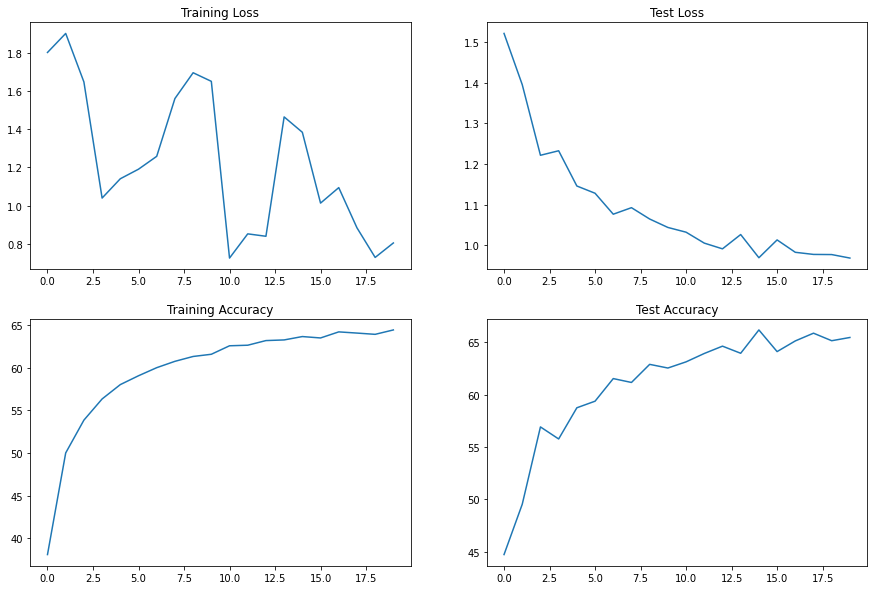

In [ ]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR
model = customModel.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
EPOCHS = 20
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_acc,tr_losses = trainModel.train(model, device, train_loader, optimizer, epoch,'Normal', True, EPOCHS-1)
    train_losses.append(tr_losses)
    train_acc.append(tr_acc)
    ts_acc,ts_loss = testModel.test(model, device, test_loader,epoch,'Normal',True, EPOCHS-1)
    test_losses.append(ts_loss)
    test_acc.append(ts_acc)    

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Architecture (With Advanced Convolution)

- change the code such that it uses GPU
- change the architecture to C1C2C3C40 (basically 3 MPs)
- total RF must be more than 44
- one of the layers must use Depthwise Separable Convolution
- one of the layers must use Dilated Convolution
- use GAP (compulsory):- add FC after GAP to target #of classes   (optional)
- achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M. 

- Advanced Convolution with 604K Params
- Test set: Average loss: 0.4949, Accuracy: 8409/10000 (84.09%)

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = vs_net.Net1().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          18,496
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1,

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.3286447525024414 Batch_id=0 Accuracy=12.50:   0%|          | 0/782 [00:00<?, ?it/s]/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/trainModel.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device).clone().detach().requires_grad_(True)
Loss=1.6304852962493896 Batch_id=781 Accuracy=47.08: 100%|██████████| 782/782 [00:44<00:00, 17.42it/s]
/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/testModel.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, d


Test set: Average loss: 1.1158, Accuracy: 6004/10000 (60.04%)

EPOCH: 1


Loss=0.6287285089492798 Batch_id=781 Accuracy=64.57: 100%|██████████| 782/782 [00:44<00:00, 17.50it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9729, Accuracy: 6622/10000 (66.22%)

EPOCH: 2


Loss=0.6326096057891846 Batch_id=781 Accuracy=71.65: 100%|██████████| 782/782 [00:43<00:00, 17.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7517, Accuracy: 7383/10000 (73.83%)

EPOCH: 3


Loss=1.0369727611541748 Batch_id=781 Accuracy=75.37: 100%|██████████| 782/782 [00:43<00:00, 18.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7497, Accuracy: 7464/10000 (74.64%)

EPOCH: 4


Loss=0.37111905217170715 Batch_id=781 Accuracy=78.10: 100%|██████████| 782/782 [00:43<00:00, 18.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6569, Accuracy: 7805/10000 (78.05%)

EPOCH: 5


Loss=0.8727929592132568 Batch_id=781 Accuracy=79.44: 100%|██████████| 782/782 [00:42<00:00, 18.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6815, Accuracy: 7709/10000 (77.09%)

EPOCH: 6


Loss=0.9919124841690063 Batch_id=781 Accuracy=81.14: 100%|██████████| 782/782 [00:42<00:00, 18.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6141, Accuracy: 7966/10000 (79.66%)

EPOCH: 7


Loss=0.863410472869873 Batch_id=781 Accuracy=82.18: 100%|██████████| 782/782 [00:42<00:00, 18.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5938, Accuracy: 7993/10000 (79.93%)

EPOCH: 8


Loss=0.2595788836479187 Batch_id=781 Accuracy=82.75: 100%|██████████| 782/782 [00:43<00:00, 18.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5087, Accuracy: 8295/10000 (82.95%)

EPOCH: 9


Loss=0.5384660959243774 Batch_id=781 Accuracy=84.07: 100%|██████████| 782/782 [00:42<00:00, 18.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5067, Accuracy: 8271/10000 (82.71%)

EPOCH: 10


Loss=0.5908805727958679 Batch_id=781 Accuracy=84.90: 100%|██████████| 782/782 [00:41<00:00, 18.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5400, Accuracy: 8189/10000 (81.89%)

EPOCH: 11


Loss=0.7532641887664795 Batch_id=781 Accuracy=85.34: 100%|██████████| 782/782 [00:41<00:00, 18.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4897, Accuracy: 8339/10000 (83.39%)

EPOCH: 12


Loss=0.09998415410518646 Batch_id=781 Accuracy=85.96: 100%|██████████| 782/782 [00:41<00:00, 18.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4935, Accuracy: 8303/10000 (83.03%)

EPOCH: 13


Loss=0.4301600158214569 Batch_id=781 Accuracy=86.68: 100%|██████████| 782/782 [00:41<00:00, 18.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4794, Accuracy: 8355/10000 (83.55%)

EPOCH: 14


Loss=0.4846588671207428 Batch_id=781 Accuracy=87.05: 100%|██████████| 782/782 [00:41<00:00, 19.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4805, Accuracy: 8388/10000 (83.88%)

EPOCH: 15


Loss=0.423648476600647 Batch_id=781 Accuracy=87.58: 100%|██████████| 782/782 [00:41<00:00, 18.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5264, Accuracy: 8231/10000 (82.31%)

EPOCH: 16


Loss=0.6426000595092773 Batch_id=781 Accuracy=88.13: 100%|██████████| 782/782 [00:41<00:00, 18.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4672, Accuracy: 8436/10000 (84.36%)

EPOCH: 17


Loss=0.35861337184906006 Batch_id=781 Accuracy=88.45: 100%|██████████| 782/782 [00:42<00:00, 18.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4684, Accuracy: 8478/10000 (84.78%)

EPOCH: 18


Loss=0.22597937285900116 Batch_id=781 Accuracy=88.62: 100%|██████████| 782/782 [00:41<00:00, 18.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5071, Accuracy: 8339/10000 (83.39%)

EPOCH: 19


Loss=0.8584912419319153 Batch_id=781 Accuracy=89.20: 100%|██████████| 782/782 [00:41<00:00, 18.88it/s]



Test set: Average loss: 0.4610, Accuracy: 8509/10000 (85.09%)



Text(0.5, 1.0, 'Test Accuracy')

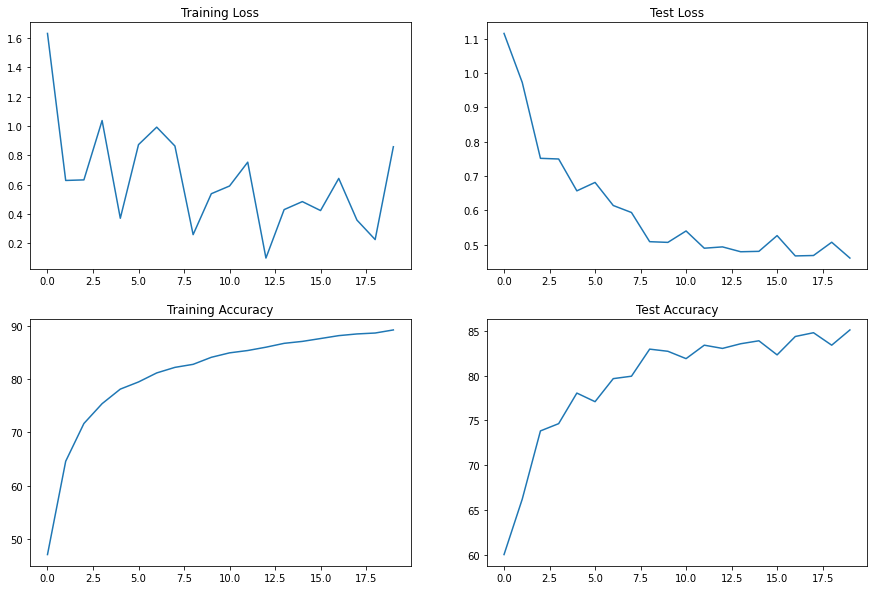

In [21]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR
model = vs_net.Net1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9)
EPOCHS = 20
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_acc,tr_losses = trainModel.train(model, device, train_loader, optimizer, epoch,'Normal', True, EPOCHS-1)
    train_losses.append(tr_losses)
    train_acc.append(tr_acc)
    ts_acc,ts_loss = testModel.test(model, device, test_loader,epoch,'Normal',True, EPOCHS-1)
    test_losses.append(ts_loss)
    test_acc.append(ts_acc)    

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## ResNet Archtecture

In [19]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = resnet.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/resnet.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/resnet.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=2.75742244720459 Batch_id=0 Accuracy=10.94:   0%|          | 0/782 [00:00<?, ?it/s]/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/trainModel.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device).clone().detach().requires_grad_(True)
Loss=0.7862831354141235 Batch_id=781 Accuracy=51.70: 100%|██████████| 782/782 [01:11<00:00, 10.94it/s]
/content/drive/My Drive/Colab Notebooks/EVA 5/08.Receptive Fields & Network Architectures/testModel.py:29: UserWarning: 


Test set: Average loss: 1.0764, Accuracy: 6270/10000 (62.70%)

EPOCH: 1


Loss=0.7489538192749023 Batch_id=781 Accuracy=72.37: 100%|██████████| 782/782 [01:10<00:00, 11.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7264, Accuracy: 7454/10000 (74.54%)

EPOCH: 2


Loss=0.43220382928848267 Batch_id=781 Accuracy=79.04: 100%|██████████| 782/782 [01:10<00:00, 11.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6657, Accuracy: 7705/10000 (77.05%)

EPOCH: 3


Loss=0.26409703493118286 Batch_id=781 Accuracy=83.17: 100%|██████████| 782/782 [01:10<00:00, 11.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5864, Accuracy: 8010/10000 (80.10%)

EPOCH: 4


Loss=0.911159098148346 Batch_id=781 Accuracy=85.83: 100%|██████████| 782/782 [01:09<00:00, 11.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6046, Accuracy: 8064/10000 (80.64%)

EPOCH: 5


Loss=1.0855915546417236 Batch_id=781 Accuracy=87.69: 100%|██████████| 782/782 [01:09<00:00, 11.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5394, Accuracy: 8221/10000 (82.21%)

EPOCH: 6


Loss=0.29601237177848816 Batch_id=781 Accuracy=89.73: 100%|██████████| 782/782 [01:09<00:00, 11.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4760, Accuracy: 8421/10000 (84.21%)

EPOCH: 7


Loss=1.1363688707351685 Batch_id=781 Accuracy=91.34: 100%|██████████| 782/782 [01:09<00:00, 11.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5885, Accuracy: 8259/10000 (82.59%)

EPOCH: 8


Loss=0.5746935606002808 Batch_id=781 Accuracy=92.43: 100%|██████████| 782/782 [01:09<00:00, 11.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5379, Accuracy: 8395/10000 (83.95%)

EPOCH: 9


Loss=0.6827925443649292 Batch_id=781 Accuracy=93.63: 100%|██████████| 782/782 [01:09<00:00, 11.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5403, Accuracy: 8455/10000 (84.55%)

EPOCH: 10


Loss=0.15598773956298828 Batch_id=781 Accuracy=94.58: 100%|██████████| 782/782 [01:09<00:00, 11.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5616, Accuracy: 8492/10000 (84.92%)

EPOCH: 11


Loss=0.24526840448379517 Batch_id=781 Accuracy=95.46: 100%|██████████| 782/782 [01:09<00:00, 11.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5336, Accuracy: 8487/10000 (84.87%)

EPOCH: 12


Loss=0.049218662083148956 Batch_id=781 Accuracy=96.11: 100%|██████████| 782/782 [01:09<00:00, 11.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5390, Accuracy: 8531/10000 (85.31%)

EPOCH: 13


Loss=0.0021871693897992373 Batch_id=781 Accuracy=96.89: 100%|██████████| 782/782 [01:09<00:00, 11.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5908, Accuracy: 8497/10000 (84.97%)

EPOCH: 14


Loss=0.07394437491893768 Batch_id=781 Accuracy=97.12: 100%|██████████| 782/782 [01:09<00:00, 11.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5533, Accuracy: 8568/10000 (85.68%)

EPOCH: 15


Loss=0.5329904556274414 Batch_id=781 Accuracy=97.48: 100%|██████████| 782/782 [01:09<00:00, 11.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5832, Accuracy: 8572/10000 (85.72%)

EPOCH: 16


Loss=0.23050697147846222 Batch_id=781 Accuracy=97.44: 100%|██████████| 782/782 [01:09<00:00, 11.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5419, Accuracy: 8624/10000 (86.24%)

EPOCH: 17


Loss=0.059702616184949875 Batch_id=781 Accuracy=97.99: 100%|██████████| 782/782 [01:09<00:00, 11.25it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5688, Accuracy: 8639/10000 (86.39%)

EPOCH: 18


Loss=0.008053247816860676 Batch_id=781 Accuracy=98.39: 100%|██████████| 782/782 [01:09<00:00, 11.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5667, Accuracy: 8642/10000 (86.42%)

EPOCH: 19


Loss=0.03406280279159546 Batch_id=781 Accuracy=98.51: 100%|██████████| 782/782 [01:09<00:00, 11.25it/s]



Test set: Average loss: 0.5658, Accuracy: 8654/10000 (86.54%)



Text(0.5, 1.0, 'Test Accuracy')

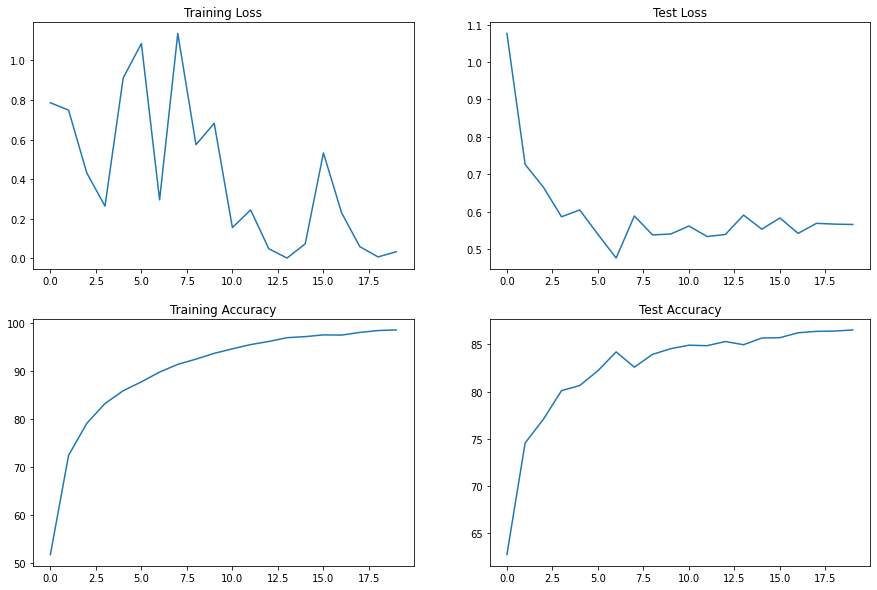

In [20]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR
model = resnet.ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
EPOCHS = 20
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    tr_acc,tr_losses = trainModel.train(model, device, train_loader, optimizer, epoch,'Normal', True, EPOCHS-1)
    train_losses.append(tr_losses)
    train_acc.append(tr_acc)
    ts_acc,ts_loss = testModel.test(model, device, test_loader,epoch,'Normal',True, EPOCHS-1)
    test_losses.append(ts_loss)
    test_acc.append(ts_acc)    

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")